# LSTM Stock Price Prediction Model

This notebook implements an LSTM model for stock price prediction that will be used in the Flask application. The model includes:
- Data preprocessing and visualization
- LSTM model architecture matching the Flask app requirements
- Model training and evaluation
- Model saving for Flask deployment

## Setup and Dependencies

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Data Collection and Preprocessing

In [5]:
def fetch_stock_data(symbol, start_date='2005-01-01'):
    """Fetch stock data from Yahoo Finance."""
    end_date = date.today().strftime('%Y-%m-%d')
    df = yf.download(symbol, start_date, end_date)
    return df

# Fetch data for demonstration (using SBIN.NS as example)
df = fetch_stock_data('SBIN.NS')
# Check if data is fetched correctly
print(f"Data shape: {df.shape}")
df.head()

[*********************100%***********************]  1 of 1 completed

Data shape: (5036, 5)


Price,Close,High,Low,Open,Volume
Ticker,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS
Date,,,,,
2005-01-03,47.114105,47.627816,46.708163,47.024296,22590407
2005-01-04,46.693802,47.340429,46.424373,47.336839,26206416
2005-01-05,44.362347,47.117704,42.461975,46.697397,52142335
2005-01-06,43.417542,45.184993,42.831982,44.204272,47719200
2005-01-07,44.233021,44.541964,43.485805,43.783974,30985674


In [6]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS
Date,,,,,
2025-05-26,794.400024,797.549988,789.200012,792.000000,4965466
2025-05-27,793.700012,801.349976,790.049988,794.400024,11995043
2025-05-28,796.549988,798.900024,792.650024,794.500000,6873519
2025-05-29,797.349976,800.400024,791.349976,799.000000,14034127
2025-05-30,812.299988,814.500000,792.599976,798.000000,22037314


## Data Visualization

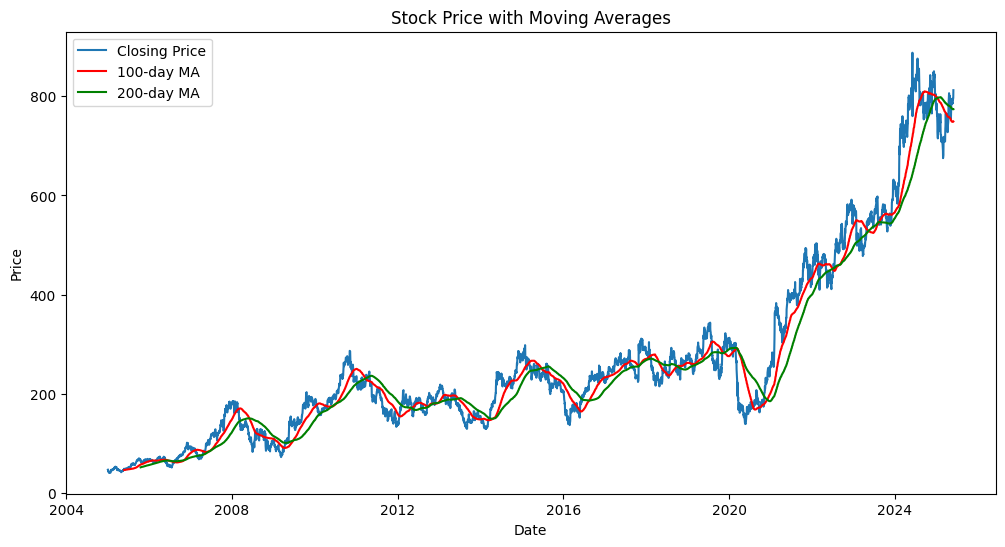

In [7]:
# Plot closing price with moving averages
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price')
plt.plot(df['Close'].rolling(100).mean(), 'r', label='100-day MA')
plt.plot(df['Close'].rolling(200).mean(), 'g', label='200-day MA')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Data Preparation

In [8]:
# Inspect column names
print(df.columns)

# Prepare data for LSTM model
df_processed = df.reset_index()
# Drop columns safely
df_processed = df_processed.drop(['Date', 'Adj Close'], axis=1, errors='ignore')

# Split into training and testing sets
training_size = int(len(df_processed) * 0.70)
data_training = pd.DataFrame(df_processed['Close'][0:training_size])
data_testing = pd.DataFrame(df_processed['Close'][training_size:])

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training)

# Create sequences for training
x_train = []
y_train = []
for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(f"Training data shape: {x_train.shape}")


MultiIndex([( 'Close', 'SBIN.NS'),
            (  'High', 'SBIN.NS'),
            (   'Low', 'SBIN.NS'),
            (  'Open', 'SBIN.NS'),
            ('Volume', 'SBIN.NS')],
           names=['Price', 'Ticker'])
Training data shape: (3425, 100, 1)


C:\Users\kumar\AppData\Local\Temp\ipykernel_24000\2985100205.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_processed = df_processed.drop(['Date', 'Adj Close'], axis=1, errors='ignore')


## LSTM Model Architecture

In [9]:
# Create LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(100, 1)),
    Dropout(0.2),
    LSTM(60, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(80, activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(120, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\RK\my_project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - loss: 0.0808 - val_loss: 0.0188
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0104 - val_loss: 0.0061
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.0087 - val_loss: 0.0044
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0067 - val_loss: 0.0085
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0067 - val_loss: 0.0147
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0063 - val_loss: 0.0163
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0049 - val_loss: 0.0103
Epoch 11/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 12/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 11

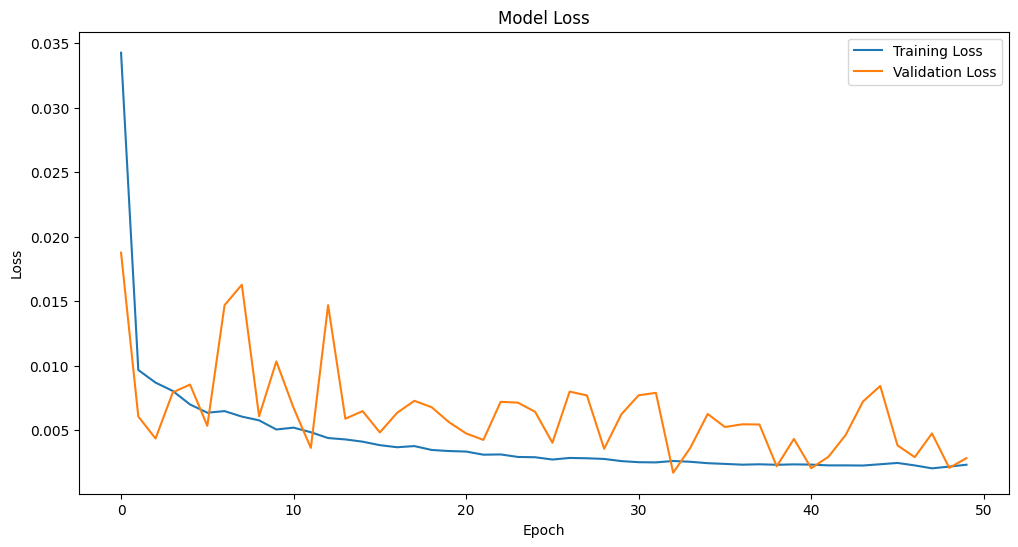

In [10]:
# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Evaluation

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


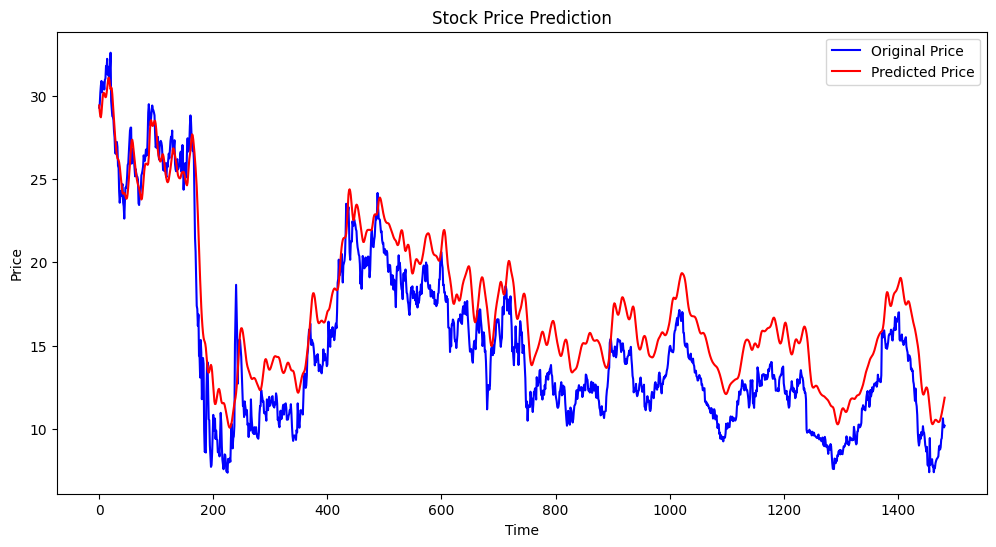

In [9]:
# Prepare test data
past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
input_data = scaler.transform(final_df)

x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

# Make predictions
y_predicted = model.predict(x_test)

# Scale back to original
scale_factor = 1/scaler.scale_[0]
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Save Model for Flask Application

In [10]:
# Save the model
model.save('keras_model.h5')
print("Model saved successfully as 'keras_model.h5'")

Model saved successfully as 'keras_model.h5'
